## Historical Price Data EDA

In [1]:
import os
os.chdir(os.environ['PWD'])

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
from conf import settings as sts
from conf import utils as uts
import re
import string
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor

#### Import Historical Data

In [3]:
dataset_filtered = pd.read_csv(sts.LOCAL_DATA_PATH+"final_prices_dataset_filtered.csv")

In [4]:
dataset_filtered

,date,group,product,market,mean_price
0,2013-01-01,verduras y hortalizas,pepino cohombro,cucuta cenabastos,790.0
1,2013-02-01,verduras y hortalizas,pepino cohombro,cucuta cenabastos,638.0
2,2013-03-01,verduras y hortalizas,pepino cohombro,cucuta cenabastos,705.0
3,2013-04-01,verduras y hortalizas,pepino cohombro,cucuta cenabastos,518.0
4,2013-05-01,verduras y hortalizas,pepino cohombro,cucuta cenabastos,550.0
...,...,...,...,...,...
406023,2022-07-01,frutas,limon mandarino,armenia retiro,1800.0
406024,2022-08-01,frutas,limon mandarino,armenia retiro,1887.0
406025,2022-09-01,frutas,limon mandarino,armenia retiro,2654.0
406026,2022-10-01,frutas,limon mandarino,armenia retiro,2303.0


In [5]:
dataset_filtered['date'] = pd.to_datetime(dataset_filtered['date'])

## Time Series Forecasting

In [6]:
date_range = pd.date_range(
    start = dataset_filtered['date'].min(), 
    end = dataset_filtered['date'].max(), 
    freq = 'MS'
)

In [7]:
price_series = dataset_filtered.loc[
    (dataset_filtered['group'] == 'frutas')&
    (dataset_filtered['product'] == 'manzana roja importada')&
    (dataset_filtered['market'] == 'medellin central mayorista de antioquia'),
    ['mean_price', 'date']
].set_index('date').reindex(date_range).squeeze()

In [9]:
y = price_series.copy()

In [10]:
series_start_period = y.first_valid_index()

In [11]:
test_size = 3

In [12]:
y_train = y[series_start_period:].iloc[:-test_size]
y_test = y.iloc[-test_size:]

In [13]:
y_train.tail()

2022-04-01    7492.0
2022-05-01    7014.0
2022-06-01    6774.0
2022-07-01    7016.0
2022-08-01    7513.0
Freq: MS, Name: mean_price, dtype: float64

In [14]:
y_test.head()

2022-09-01    8101.0
2022-10-01    7928.0
2022-11-01    8228.0
Freq: MS, Name: mean_price, dtype: float64

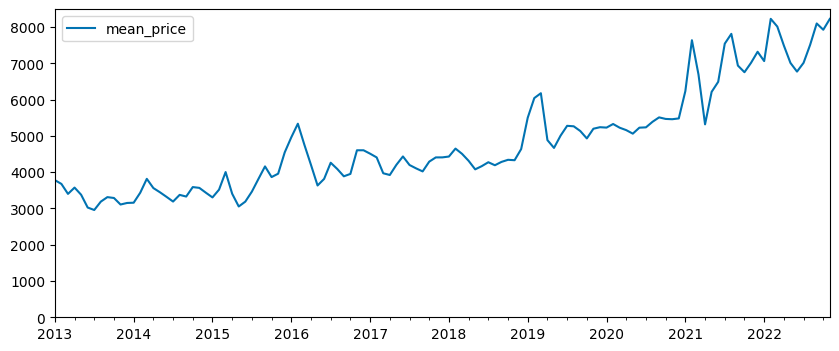

In [15]:
plt.figure(figsize=(10,4))
y.plot()
plt.ylim(bottom=0)
plt.legend()
plt.show()

#### Time Series Decomposition w/ LOESS

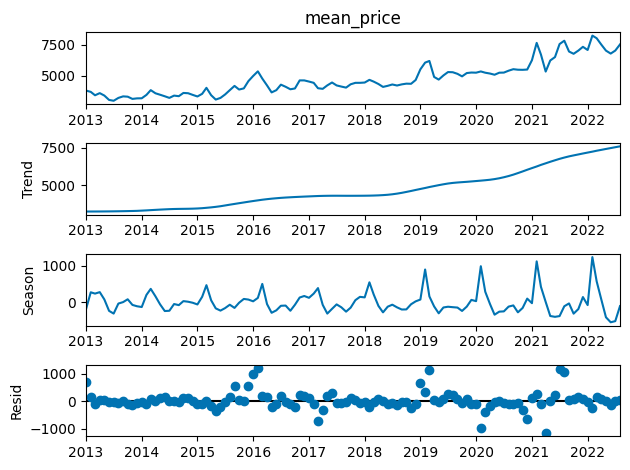

In [16]:
stl = STL(y_train, period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()

In [17]:
f_t = max(0, 1 - res_robust.resid.var()/(res_robust.trend + res_robust.resid).var())
print("f_t", f_t)

f_t 0.9335900191489662


In [18]:
f_s = max(0, 1 - res_robust.resid.var()/(res_robust.seasonal + res_robust.resid).var())
print("f_s", f_s)

f_s 0.3650584451697708


### Input Features

#### Trend and Seasonality

In [19]:
dp = DeterministicProcess(
    index = y_train.index,
    constant = True,
    order = (2 if f_t > 0.5 else 0),
    drop = True,
    seasonal = (True if f_s > 0.5 else False)
)

In [20]:
# Trend Component + Seasonality (if significant)
X_1_train = dp.in_sample()
X_1_test = dp.out_of_sample(steps=y_test.shape[0])

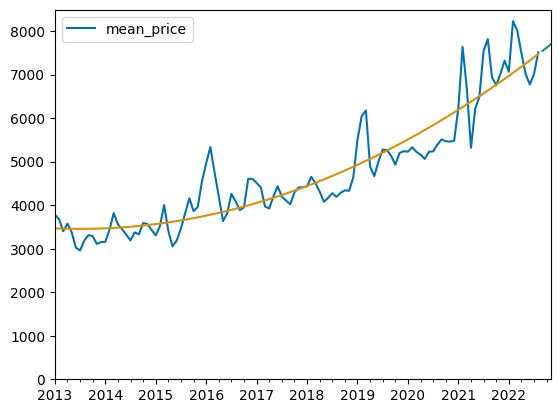

In [21]:
model_1 = LinearRegression().fit(X_1_train, y_train)
y_fitted_1 = pd.Series(model_1.predict(X_1_train), index=X_1_train.index)
y_pred_1 = pd.Series(model_1.predict(X_1_test), index=X_1_test.index)
ax = y_train.plot()
ax = y_fitted_1.plot()
ax = y_pred_1.plot()
ax.legend()
plt.ylim(bottom=0)
plt.show()

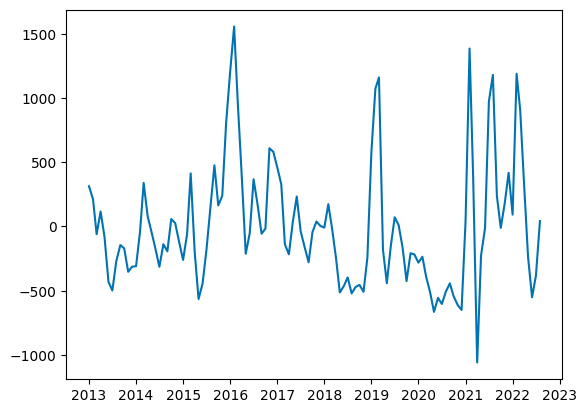

In [22]:
residuals = y_train - y_fitted_1
plt.plot(residuals)
plt.show()

In [23]:
X_2_train = uts.make_lags(residuals, 3).dropna()
X_2_test = X_2_train.iloc[-1:]
y_2_train = uts.make_multistep_target(residuals, test_size).dropna()

In [24]:
y_2_train, X_2_train = y_2_train.align(X_2_train, join='inner', axis=0)

In [25]:
X_2_train.tail()

,y_lag_1,y_lag_2,y_lag_3
2022-02-01,91.997169,417.627659,180.581578
2022-03-01,1187.690107,91.997169,417.627659
2022-04-01,904.706475,1187.690107,91.997169
2022-05-01,310.046271,904.706475,1187.690107
2022-06-01,-239.290503,310.046271,904.706475


In [26]:
y_2_train.tail()

,y_step_1,y_step_2,y_step_3
2022-02-01,1187.690107,904.706475,310.046271
2022-03-01,904.706475,310.046271,-239.290503
2022-04-01,310.046271,-239.290503,-551.303848
2022-05-01,-239.290503,-551.303848,-381.993765
2022-06-01,-551.303848,-381.993765,41.639748


In [27]:
X_2_test

,y_lag_1,y_lag_2,y_lag_3
2022-08-01,-381.993765,-551.303848,-239.290503


In [28]:
model = MultiOutputRegressor(KNeighborsRegressor())
model.fit(X_2_train, y_2_train)

MultiOutputRegressor(estimator=KNeighborsRegressor())

In [29]:
y_fitted_2 = pd.DataFrame(model.predict(X_2_train), index=X_2_train.index, columns=y_2_train.columns)
y_pred_2 = pd.Series(model.predict(X_2_test).reshape(-1,), index = y_pred_1.index)

In [30]:
print("y_fitted_2.shape",y_fitted_2.shape)
print("y_pred_2.shape",y_pred_2.shape)

y_fitted_2.shape (111, 3)
y_pred_2.shape (3,)


In [31]:
y_pred = y_pred_1 + y_pred_2
y_fitted = y_fitted_1 + y_fitted_2['y_step_1']

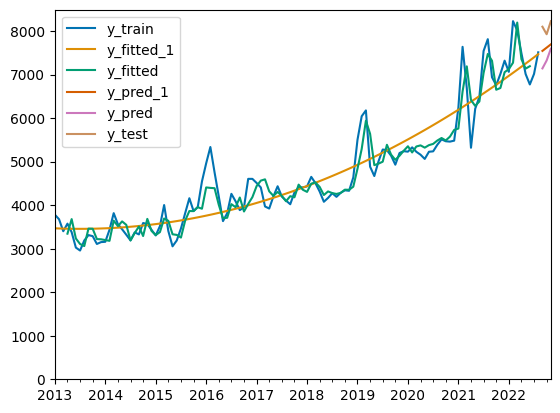

In [32]:
ax = y_train.plot(label = 'y_train')
ax = y_fitted_1.plot(label = 'y_fitted_1')
ax = y_fitted.plot(label = 'y_fitted')
ax = y_pred_1.plot(label = 'y_pred_1')
ax = y_pred.plot(label = 'y_pred')
ax = y_test.plot(label = 'y_test')
ax.legend()
plt.ylim(bottom=0)
plt.show()

### Evaluation Metrics

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#### Training Set

In [37]:
print(f"MAPE y_train - y_fitted_1 = {mean_absolute_percentage_error(y_train, y_fitted_1)}")

MAPE y_train - y_fitted_1 = 0.07391271724681825


In [38]:
y_train_ri, y_fitted = y_train.dropna().align(y_fitted.dropna(), join='inner', axis=0)

In [39]:
print(f"MAPE y_train - y_fitted = {mean_absolute_percentage_error(y_train_ri, y_fitted)}")

MAPE y_train - y_fitted = 0.04551653747946243


In [40]:
print(f"MAPE y_test - y_pred_1 = {mean_absolute_percentage_error(y_test, y_pred_1)}")

MAPE y_test - y_pred_1 = 0.057377855480354616


In [41]:
print(f"MAPE y_test - y_pred = {mean_absolute_percentage_error(y_test, y_pred)}")

MAPE y_test - y_pred = 0.09043635987298414
